# The Ladder of Causation in Business
The “Ladder of Causation” (Pearl, 2018) helps distinguish between descriptive, causal, and counterfactual reasoning.

> It clarifies whether you’re observing correlations, testing interventions, or reasoning about what could have happened.

## Business workflow to “climb the ladder”
1. **Start with prediction**: Build a model that predicts conversion → get baseline understanding.
2. **Move to interventions**: Validate or run experiments to test key drivers → estimate lift.
3. **Use counterfactuals selectively**: Build simulations or SCMs to answer “what if” questions → plan scenarios and policies.

| Level | Concept | Question Type | Typical Business Use Case | Example |
|:------|:---------|:---------------|:----------------------------|:----------|
| **1. Association** | Correlation & pattern recognition | “What is happening?” | Descriptive analytics, dashboards, customer segmentation | Customers who buy A also buy B |
| **2. Intervention** | Causal effect of actions | “What if we do X?” | A/B testing, marketing attribution, pricing experiments | What happens to conversion if we increase email frequency? |
| **3. Counterfactuals** | Hypothetical alternative outcomes | “What if we had done X instead of Y?” | Customer lifetime impact, churn prevention, ROI simulation | Would customers have churned if we hadn’t raised prices? |

## How to Approach Counterfactuals in Practice
> Counterfactual reasoning answers **“What would have happened if things were different?**”

In analytics, this means carefully defining treatments, outcomes, and confounders to simulate alternative realities.

| Step | Goal | Example Question | Typical Method |
|:------|:------|:------------------|:----------------|
| **1. Define the Treatment** | Identify the action/intervention | “Received the retention email” vs. “Did not receive it” | Binary treatment variable |
| **2. Define the Outcome** | Specify what you want to compare | “Customer churned (1/0)” | Dependent variable in regression or model |
| **3. Control for Confounders** | Remove bias from non-random assignment | “High-value customers were more likely to get the email” | Propensity score matching, regression adjustment |
| **4. Estimate the Effect** | Compute the causal difference | “How did churn probability change due to treatment?” | Average Treatment Effect (ATE) |
| **5. Interpret the Counterfactual** | Translate to business insight | “Churn would have been 5% higher without the campaign” | Causal uplift modeling, scenario simulation |

### Implementation Checklist
| Task | How | Example |
|:-----|:----|:--------|
| **1. Define variables** | Identify treatment (X), outcome (Y), and covariates (Z) | `X = discount`, `Y = subscription`, `Z = engagement, income` |
| **2. Build causal graph** | Draw a DAG or define structural equations to express causal assumptions | `engagement → discount → subscription`, `engagement → subscription` |
| **3. Identify causal query** | Express the causal quantity you want (using do-notation or potential outcomes) | `E[Y \| do(X=1)]` — expected outcome if everyone received a discount; or `ATE = E[Y(1) - Y(0)]` — average treatment effect |
| **4. Estimate model** | Choose an estimation method consistent with identification | Propensity score matching, regression adjustment, doubly robust estimators, causal forests (e.g. via DoWhy or EconML) |
| **5. Validate / Sensitivity** | Check assumptions and robustness; compare to experiments if available | Placebo tests, covariate balance checks, sensitivity to unobserved confounding, compare with A/B test estimates |
| **6. Compute counterfactuals** | Use the abduction → action → prediction procedure on a structural model | Example: “Would user 42 have subscribed without receiving a discount?” |


## Example
A minimal, but fully runnable and conceptually tied to the above.

**Scenario**
* A SaaS company offers discounts to some users.
* We observe:
  * discount (0 or 1)
  * engagement (how much they used the trial)
  * subscribed (0 or 1 outcome)
* **Goal**: estimate the effect of discount and answer a counterfactual question.

In [11]:
# %% Install libraries (if needed)
#%pip install dowhy pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dowhy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from dowhy import CausalModel

# 1️⃣ Simulate simple business data
np.random.seed(42)
n = 1000

# Engagement drives both discount targeting and subscription
engagement = np.random.normal(0, 1, n)

# Higher engagement increases chance of being offered a discount (targeting bias)
p_discount = 1 / (1 + np.exp(- (0.5 * engagement - 0.2)))
discount = np.random.binomial(1, p_discount)

# True causal effect of discount on subscription = +0.2
# Engagement also increases subscription
p_subscribe = 1 / (1 + np.exp(- (1.0 * engagement + 0.8 * discount - 0.5)))
subscribed = np.random.binomial(1, p_subscribe)

df = pd.DataFrame({
    "engagement": engagement,
    "discount": discount,
    "subscribed": subscribed
})

df.head()

,engagement,discount,subscribed
0,0.496714,1,1
1,-0.138264,0,0
2,0.647689,0,1
3,1.523030,0,1
4,-0.234153,0,1


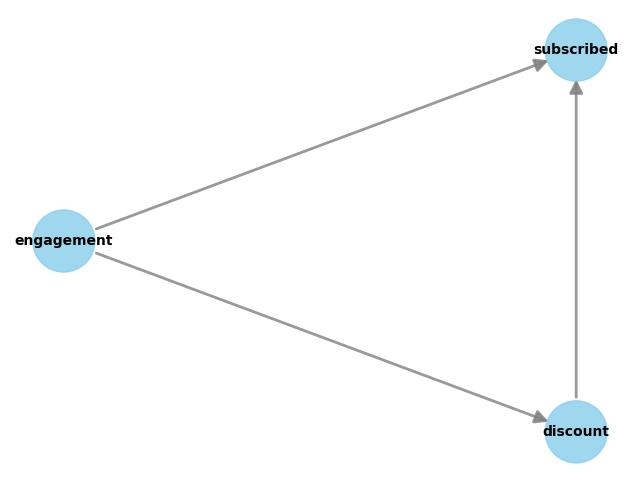

In [12]:
# 2️⃣ Define and visualize causal graph

causal_graph = """
digraph {
engagement -> discount;
engagement -> subscribed;
discount -> subscribed;
}
"""

# 3️⃣ Build the causal model
model = CausalModel(
    data=df,
    treatment="discount",
    outcome="subscribed",
    graph=causal_graph
)
model.view_model()

In [13]:
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")
print("DoWhy ATE estimate:", estimate.value)

# 2) Train a straightforward outcome model P(Y | X, Z)
X = df[["discount", "engagement"]]  # treatment + covariates
y = df["subscribed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
clf = LogisticRegression(solver="lbfgs", max_iter=1000)
clf.fit(X_train, y_train)

# 3) Choose a specific user (index 5 in this example) and compute potential outcomes
user = df.iloc[5:6]   # keep as DataFrame
user_z = user[["engagement"]].copy()

# Build two rows for treatment=1 and treatment=0
user_t1 = pd.DataFrame({"discount": [1], "engagement": user_z["engagement"].values})
user_t0 = pd.DataFrame({"discount": [0], "engagement": user_z["engagement"].values})

p_t1 = clf.predict_proba(user_t1)[0,1]  # P(Y=1 | do/assume X=1, Z)
p_t0 = clf.predict_proba(user_t0)[0,1]  # P(Y=1 | do/assume X=0, Z)

print(f"User index {user.index[0]} predicted P(subscribe | discount=1): {p_t1:.3f}")
print(f"User index {user.index[0]} predicted P(subscribe | discount=0): {p_t0:.3f}")
print(f"Estimated individual uplift (treatment effect approx): {p_t1 - p_t0:.3f}")

DoWhy ATE estimate: 0.173
User index 5 predicted P(subscribe | discount=1): 0.529
User index 5 predicted P(subscribe | discount=0): 0.296
Estimated individual uplift (treatment effect approx): 0.233


**Interpretation & Limitations**
* This gives you two potential outcome probabilities for the same user under X=1 and X=0.
* It’s an approximation of the counterfactual — valid only if you have correctly measured confounders (no hidden confounders).
* It follows the plug-in approach, not the full abduction-action-prediction workflow of structural counterfactuals.

# References
https://chatgpt.com/g/g-p-68d0f0e9c9188191be281faa1bb4a646-adb/c/68e9ed3a-0164-832e-95d8-2f3764668c85